In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import re

In [2]:
#for automaticaly cleaning the dataframes without needing to run lots of cells every time.
def clean_dataframe(data,csv_name = "data"):
    #Also Saves the clean dataframe as cleaned_{csv_name}.csv
    
    initial_len =len(data) #for logging
    for col in data.columns:
        print(f'* Initial {col} values %: {100 - (len(data[data[col].isna()])/len(data[col]))*100:.2f}%\n')
    
    #Utils functions
    def clean_release_date(value):
        if value:
            match = re.search(r'(\d+.*)',str(value))
            if match:
                match= match[0].replace(",","")
                return match
        else:
            return "Unknown"
        
    def extract_publisher(value):
        match = re.search(r'(Publisher)(.)(.+)(Release)',str(value))
        if match:
            match= match[3]
            return match
        else:
            return "Unknown"

    def extract_developer(value):
        match = re.search(r'(Developer)(.)(.+)(Release)',str(value))
        if match:
            match= match[3]
            return match
        else:
            return "Unknown"
    
    def clean_publisher_developer(value):
        match = re.search(r'(.+)(Franchise.+)',str(value))
        if match:
            match= match[1]
            return match
        else:
            return value
        
    def check_if_game(value):
        if re.search(r'(Soundtrack|DLC)',value):
            return True
        else:
            return False 
        
    def clean_price(value):
        match = re.search(r'(\d+\.\d+)',str(value))
        if match:
            return float(match[0].strip("ARS$ "))
        else:
            return 0.
    
    def clean_sentiment(value):
        if re.search(r'user reviews|nan',str(value)) :
            return "Unknown"
        else:
            return value
        
    #Cleaning process
    
    #deleteing cols that I will not need
    del data["specs"] 
    del data["n_reviews"]
    
    data["app_name"] = data["app_name"].fillna(data["title"])
    data["title"] = data["title"].fillna(data["app_name"])

    data.dropna(subset = ["app_name","id","title"], inplace=True)  ##Remove rows without id or app_names
    
    data["release_date"] = data["release_date"].apply(clean_release_date)
    data["release_date"]= data["release_date"].fillna("unknown")    
    
    data = data.rename(columns={'developer': 'publisher', 'publisher': 'developer'}) # fix where dev and publisher col names were swapped by scraper
    
    data["publisher"] = data["publisher"].apply(extract_publisher)
    data["developer"] = data["developer"].apply(extract_developer)
    data["developer"] = data["developer"].apply(clean_publisher_developer)
    data["publisher"] = data["publisher"].apply(clean_publisher_developer)
    
    #checking if its a game or a DLC or a sountrack and dropping them
    not_game = [check_if_game(value) for value in data["app_name"].values] 
    data["not_game"] = not_game
    data.drop(data[data["not_game"] == True].index, inplace = True)
    del data["not_game"]
    
    #cleaning prices, filling empty discount prices rows with the normal price
    data["price"] = data["price"].apply(clean_price)
    data["discount_price"] = data["discount_price"].fillna(data["price"])
    data["discount_price"] = data["discount_price"].apply(clean_price)
       
    #transforming early access row into 1s and 0s
    data["early_access"] = data["early_access"].astype(int)
    
    #filling null generes and tags with Unkown
    data["genres"] = data["genres"].fillna("Unkown")  
    data["tags"] = data["tags"].fillna("Unkown") 
    
    #cleaning sentiment
    data["sentiment"] = data["sentiment"].apply(clean_sentiment) 
    
    #dropping any row that couldn't be saved or cleaned
    data.dropna(subset = ["genres","developer","publisher","sentiment","tags",
                          "early_access","price","discount_price","release_date","app_name","id","title"], inplace=True)    
    
    data["id"].drop_duplicates()

    print(f'\nInitial data lenght: {initial_len}\nOutput data lenght: {len(data)}\nRaw Data Lost: {100-((len(data)/initial_len)*100):.2f}%\n\nNaN values check: \n{data.isna().sum()}')
    
    data = data.reset_index(level=0,drop=True)
    
    data.to_csv(f"cleaned_{csv_name}.csv") 
    
    return data

In [3]:
data_raw = pd.read_csv("raw_data.csv")
#cleaning the scrapped data
data = clean_dataframe(data_raw.copy())

* Initial app_name values %: 99.99%

* Initial developer values %: 93.08%

* Initial discount_price values %: 33.51%

* Initial early_access values %: 100.00%

* Initial genres values %: 90.99%

* Initial id values %: 99.99%

* Initial metascore values %: 4.77%

* Initial n_reviews values %: 0.00%

* Initial price values %: 90.70%

* Initial publisher values %: 82.30%

* Initial release_date values %: 93.61%

* Initial reviews_url values %: 99.99%

* Initial sentiment values %: 76.29%

* Initial specs values %: 0.00%

* Initial tags values %: 97.93%

* Initial title values %: 93.79%

* Initial url values %: 100.00%


Initial data lenght: 48727
Output data lenght: 45350
Raw Data Lost: 6.93%

NaN values check: 
app_name              0
publisher             0
discount_price        0
early_access          0
genres                0
id                    0
metascore         43046
price                 0
developer             0
release_date          0
reviews_url           0
sentiment        

About 95% of the metascores where empty,that might be due to low reviews or that the game lacks of reviews or a scrapper error, which is pretty bad since it was the feature I wanted to predict.Lets Check this null scores.

In [4]:
data.loc[data.metascore.isna()].head(10)

,app_name,publisher,discount_price,early_access,genres,id,metascore,price,developer,release_date,reviews_url,sentiment,tags,title,url
0,Gogte,OsoArcade,78.99,1,"Action,Adventure,Early Access",1440910.0,NaN,78.99,OsoOsoArcade,28 Jan 2022,http://steamcommunity.com/app/1440910/reviews/...,Unknown,"FPS,Dungeon Crawler,Action,Puzzle,Action-Adven...",Gogte,https://store.steampowered.com/app/1440910/Gogte/
1,I've Seen Everything - More Fishes,NLB project,0.00,0,"Casual,Indie",1807515.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807515/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Fishes,https://store.steampowered.com/app/1807515/Ive...
2,I've Seen Everything - More Dinosaurs,NLB project,0.00,0,"Casual,Indie",1807514.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807514/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Dinosaurs,https://store.steampowered.com/app/1807514/Ive...
3,Mini Mini-Golf,Piece Of Voxel,77.99,0,"Casual,Indie,Simulation,Sports,Strategy",1874400.0,NaN,129.99,Piece Of VoxelPiece Of Voxel,28 Jan 2022,http://steamcommunity.com/app/1874400/reviews/...,Unknown,"Casual,Golf,Simulation,Logic,Strategy,Family F...",Mini Mini-Golf,https://store.steampowered.com/app/1874400/Min...
4,Rogue Dungeon,Cerberus Gate Games,116.99,1,"Indie,RPG,Strategy,Early Access",1822640.0,NaN,129.99,Cerberus Gate GamesCerberus Gate Games,28 Jan 2022,http://steamcommunity.com/app/1822640/reviews/...,Unknown,"RPG,Adventure,Board Game,Dungeon Crawler,2D,Fa...",Rogue Dungeon,https://store.steampowered.com/app/1822640/Rog...
5,Otome No Himitsu,Rosa Special Studio,16.19,0,"Adventure,Casual,Indie,RPG",1871810.0,NaN,26.99,玫瑰工作室Rosa Special Studio,28 Jan 2022,http://steamcommunity.com/app/1871810/reviews/...,Unknown,"Adventure,RPG,Indie,Casual,Puzzle,Match 3,Stor...",Otome No Himitsu,https://store.steampowered.com/app/1871810/Oto...
6,I've Seen Everything - More Singers,NLB project,0.00,0,"Casual,Indie",1807526.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807526/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Singers,https://store.steampowered.com/app/1807526/Ive...
7,I've Seen Everything - More Persons,NLB project,0.00,0,"Casual,Indie",1807525.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807525/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Persons,https://store.steampowered.com/app/1807525/Ive...
8,I've Seen Everything - More Painters,NLB project,0.00,0,"Casual,Indie",1807524.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807524/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Painters,https://store.steampowered.com/app/1807524/Ive...
9,I've Seen Everything - More Musical Instruments,NLB project,0.00,0,"Casual,Indie",1807522.0,NaN,0.00,NLB projectNLB project,28 Jan 2022,http://steamcommunity.com/app/1807522/reviews/...,Unknown,"Indie,Casual",I've Seen Everything - More Musical Instruments,https://store.steampowered.com/app/1807522/Ive...


After checking some of the apps it was a scrapper error, so for now I have 2 two choices, fill them with the mean or drop them. I'm going to do both, work first with the mean since it would be the bigger dataset, then work with the dropped dataset and compare results. I'll do the data exploration with the cleaned scrapped data and try to see if I can also find a better solution to this problem.

In [5]:
dataset_metascore_mean = data.copy()
dataset_metascore_mean["metascore"] = dataset_metascore_mean["metascore"].fillna(dataset_metascore_mean["metascore"].mean())
dataset_metascore_mean.to_csv("dataset_metascore_mean.csv")

dataset_metascore_drop = data.copy()
dataset_metascore_drop.dropna(subset = ["metascore"], inplace=True)    
dataset_metascore_drop.reset_index(level=0,drop=True)
dataset_metascore_drop.to_csv("dataset_metascore_drop.csv")

In [6]:
len(dataset_metascore_drop) , len(dataset_metascore_mean)

(2304, 45350)

Lets start with the tags by counting how many tags each game has and how many times it ocuurs.

In [7]:
def count_tags(value):
    return (value.count(",")+1)

In [8]:
data["tag_amnt"]  = data["tags"].apply(count_tags)

data["tag_amnt"].value_counts()

20    8271
3     4595
2     4437
5     4006
4     3291
1     3259
6     2607
7     2433
8     1740
9     1441
10    1227
11    1115
13    1037
12     972
14     951
15     882
16     858
17     816
18     721
19     691
Name: tag_amnt, dtype: int64

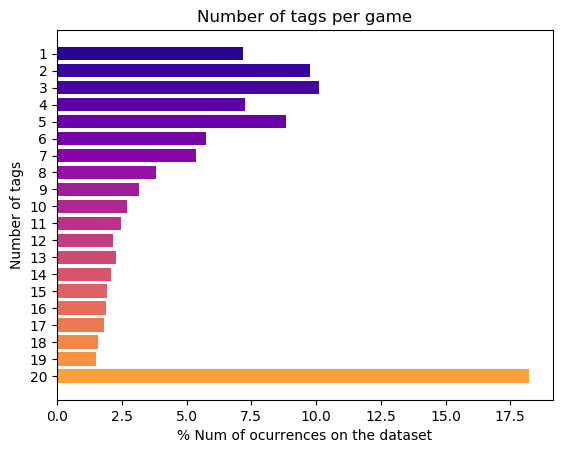

Most Frequent: [20] with 18.24 %
Top 5 tags: [20, 3, 2, 5, 4] with a total representation of 54.24%
Top 2 to 5 total repesentation: 36.01%


In [9]:
y_labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] #thre are up to 20 unique tags per game

cmap = cm.get_cmap('plasma')

color = []
for i in range(20):
    color.append(cmap(i*10 + 10))

tag_amnt = (data["tag_amnt"].value_counts() / len(data)) * 100 # getting the %
tag_amnt = tag_amnt.sort_index(ascending=True)

sum_tag_amnt_df = pd.DataFrame(tag_amnt)

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y_labels, tag_amnt,  align='center', color =  color)
ax.set_yticks(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% Num of ocurrences on the dataset')
ax.set_ylabel('Number of tags')
ax.set_title('Number of tags per game')
plt.show()

sum_tag_amnt_df = sum_tag_amnt_df.sort_values('tag_amnt',ascending=False)
most_frequent_percent = round(sum_tag_amnt_df['tag_amnt'].iloc[0],2)
representation_of_top_5 = round(sum_tag_amnt_df['tag_amnt'].iloc[0:5].sum(),2)
representation_of_top_2_to_5 = round(sum_tag_amnt_df['tag_amnt'].iloc[1:5].sum(),2)

print(f'Most Frequent: [{sum_tag_amnt_df.iloc[0].name}] with {most_frequent_percent} %\nTop 5 tags: {list(sum_tag_amnt_df.iloc[:5].index)} with a total representation of {representation_of_top_5}%\nTop 2 to 5 total repesentation: {representation_of_top_2_to_5}%')


About 18% of the games have 20 tags and 36% have between 2-5 tags.

Now lets see which are the most common tags.

In [10]:
#transforming the tags into a list, this function will also be usefull when we see the generes
def split_into_list(value):
    return value.split(",")

data['tags'] = data["tags"].apply(split_into_list)

In [11]:
#creating a function reduce the dimensionality of the data
def to_1D(series):
    return [x for _list in series for x in _list]

#Separating the tags into a new df
tags_df = to_1D(data['tags'])
tags_df= pd.DataFrame(tags_df)
tags_df = tags_df.rename(columns={0:'tag'},inplace=False)
tags_df.head()

,tag
0,FPS
1,Dungeon Crawler
2,Action
3,Puzzle
4,Action-Adventure


In [12]:
tags_df.value_counts()

tag         
Indie           27000
Action          18475
Casual          17279
Adventure       15513
Singleplayer    14643
                ...  
Hardware            8
Well-Written        8
BMX                 7
Reboot              4
Boss Rush           4
Length: 427, dtype: int64

There are 427 diferent tags in the dataset.

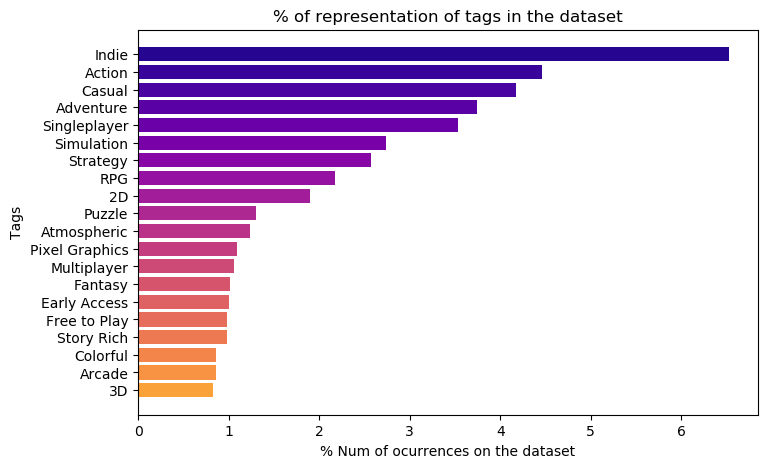

top_5_representation 22.44%
amnt_picked_representation 43.06%


,tag
Indie,6.52
Action,4.46
Casual,4.17
Adventure,3.75
Singleplayer,3.54
Simulation,2.74
Strategy,2.58
RPG,2.18
2D,1.89
Puzzle,1.31


In [13]:
AMNT_TAGS_TO_SEE = 20

y_labels = []
for i in range(AMNT_TAGS_TO_SEE):
    y_labels.append(tags_df['tag'].value_counts().keys()[:AMNT_TAGS_TO_SEE][i])

cmap = cm.get_cmap('plasma')

color = []
for i in range(20):
    color.append(cmap(i * 10 + 10))
    
tag_amnt = (tags_df["tag"].value_counts()[:AMNT_TAGS_TO_SEE] / len(tags_df)) * 100 # getting the %
tag_amnt = tag_amnt.sort_values(ascending=False)

plt.rcdefaults()
fig, ax = plt.subplots(figsize =(8, AMNT_TAGS_TO_SEE / 4))

ax.barh(y_labels, tag_amnt,  align='center', color =  color)
ax.set_yticks(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% Num of ocurrences on the dataset')
ax.set_ylabel('Tags')
ax.set_title('% of representation of tags in the dataset')
plt.show()

top_5_representation = round(tag_amnt[:5].sum(),2)
amnt_picked_representation = round(tag_amnt[:AMNT_TAGS_TO_SEE].sum(),2)
print(f'top_5_representation {top_5_representation}%\namnt_picked_representation {amnt_picked_representation}%')
pd.DataFrame(round(tag_amnt,2)).sort_values('tag',ascending=False)

The most common tag is Indie representing 6.5% of the games being ahead from the next by 2% . The top 5 tags(Indie, Action, Casual, Adventure and Singleplayer) are found in 22.4% of the games. But is there a pattern with tags and the metascore?

In [60]:
def are_tags_in_list(_list, tag):
    if _list: 
        if tag in _list:
            return True
    else:
        return False

In [15]:
tag_scores = {}
tag_list = list(tags_df['tag'].value_counts().keys())

for tag in tag_list:
    data['is_tag_in_tags']=[are_tags_in_list(tags,tag) for tags in data['tags']]
    tag_scores[tag] = data.loc[data.is_tag_in_tags == True]['metascore'].mean()

In [16]:
data_items = tag_scores.items()
tag_score_df = pd.DataFrame(list(data_items)) 

tag_score_df = tag_score_df.rename(columns={0:'tag',1:'avg_score'},inplace=False)
tag_score_df['avg_score'] = round(tag_score_df['avg_score'],2)
tag_score_df = tag_score_df.sort_values('avg_score',ascending=False)
tag_score_df

,tag,avg_score
410,Rock Music,87.0
403,Baseball,86.0
331,Looter Shooter,83.0
338,Archery,82.5
424,BMX,82.0
...,...,...
413,Instrumental Music,NaN
414,Benchmark,NaN
416,Feature Film,NaN
421,8-bit Music,NaN


In [17]:
tag_score_df.isna().sum()

tag           0
avg_score    19
dtype: int64

there are 19 null values going to fill them with mean

In [18]:
tag_score_df['avg_score'] = tag_score_df['avg_score'].fillna(tag_score_df['avg_score'].mean())
tag_score_df = tag_score_df.sort_values('avg_score',ascending=False)

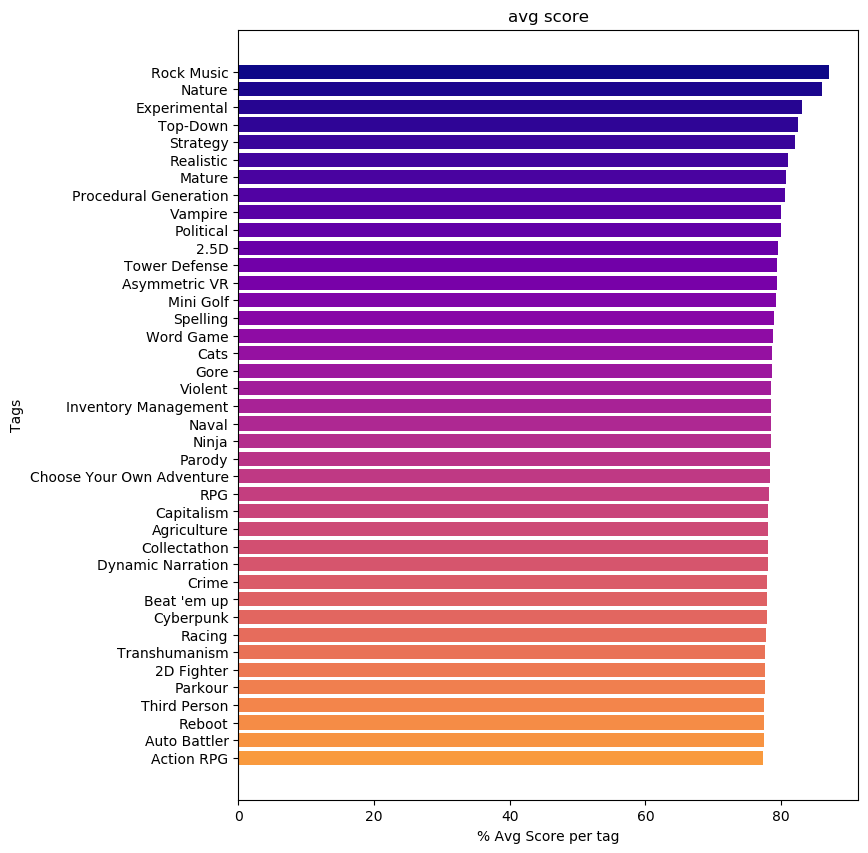

,Name,avg_score
410,Rock Music,87.00
403,Nature,86.00
331,Experimental,83.00
338,Top-Down,82.50
424,Strategy,82.00
279,Realistic,81.00
281,Mature,80.71
325,Procedural Generation,80.60
387,Vampire,80.00
344,Political,80.00


In [19]:
AMNT_TAGS_TO_SEE = 40
if(AMNT_TAGS_TO_SEE > len(tag_score_df)):
    AMNT_TAGS_TO_SEE = len(tag_score_df)
    
y_labels = []
for i in range(AMNT_TAGS_TO_SEE):
    y_labels.append(tag_score_df['tag'].value_counts().keys()[:AMNT_TAGS_TO_SEE][i])

cmap = cm.get_cmap('plasma')

color = []
for i in range(40):
    color.append(cmap(i*5))
    
tag_amnt = tag_score_df["avg_score"][:AMNT_TAGS_TO_SEE]
tag_amnt = tag_amnt.sort_values(ascending=False)

plt.rcdefaults()
fig, ax = plt.subplots(figsize =(8, AMNT_TAGS_TO_SEE / 4))

ax.barh(y_labels, tag_amnt,  align='center', color =  color)
ax.set_yticks(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% Avg Score per tag')
ax.set_ylabel('Tags')
ax.set_title('avg score')
plt.show()
df = pd.DataFrame(round(tag_amnt,2)).sort_values('avg_score',ascending=False)
df['tags'] = y_labels
df.insert(0, 'Name', df.pop('tags'))
df

In [20]:
tag_score_df.describe()

,avg_score
count,427.000000
mean,73.618333
std,3.298303
min,59.500000
25%,72.335000
50%,73.670000
75%,75.315000
max,87.000000


Seems that the best scored tags are Rock Music and nature. Lets see the underperformers

In [21]:
tag_score_df.loc[tag_score_df.avg_score <= tag_score_df.avg_score.mean()]

,tag,avg_score
13,Fantasy,73.56
273,Time Travel,73.55
102,Historical,73.55
312,Kickstarter,73.54
106,Roguelite,73.53
...,...,...
399,Wrestling,62.00
332,Soccer,62.00
362,Gambling,61.00
167,Animation & Modeling,60.00


189 tags have bellow avg scores, the worst seem to be : Intentionally Awkward Controls, Animation & Modeling, Gambling, Soccer and Wrestling. Now lets check the generes.

(<matplotlib.axes._subplots.AxesSubplot at 0x2ad58307a48>,
 3     12576
 2     11894
 1     11267
 4      5516
 5      2574
 6       955
 7       295
 8       243
 9        16
 10        9
 11        4
 12        1
 Name: gen_amnt, dtype: int64)

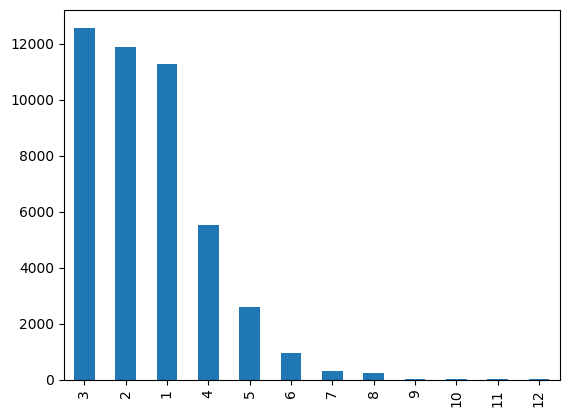

In [25]:
data["gen_amnt"]  = data["genres"].apply(count_tags)

data["gen_amnt"].value_counts().plot(kind="bar") , data["gen_amnt"].value_counts()

The mayority of the games have between 1-3 genres and there seem to be very few with more than 6 tags, lets see them to ensure that they are not scuffed.

In [45]:
data.loc[data.gen_amnt > 6].loc[data.metascore > 0].head()  #Checking if there are any games with a metascore
print("---------------------------------")
data.loc[data.gen_amnt > 6].head()

---------------------------------


,app_name,publisher,discount_price,early_access,genres,id,metascore,price,developer,release_date,reviews_url,sentiment,tags,title,url,tag_amnt,is_tag_in_tags,gen_amnt
88,深海捕鱼/Deep Fishing,Edler Fish Studio,0.00,1,"Adventure,Casual,Free to Play,Indie,Massively ...",1648550.0,NaN,0.00,Edler Fish StudioEdler Fish Studio,26 Jan 2022,http://steamcommunity.com/app/1648550/reviews/...,Positive,"[Casual, Free to Play, Simulation, Early Acces...",深海捕鱼/Deep Fishing,https://store.steampowered.com/app/1648550/Dee...,15,None,8
143,Catch them!,LTZinc,8.39,0,"Action,Adventure,Casual,Indie,Massively Multip...",1862500.0,NaN,13.99,LTZincLTZinc,21 Jan 2022,http://steamcommunity.com/app/1862500/reviews/...,Positive,"[Casual, Adventure, Simulation, 2D, Indie, Sur...",Catch them!,https://store.steampowered.com/app/1862500/Cat...,20,None,8
372,Engine Evolution 2021,Petr Šimůnek,0.00,0,"Action,Casual,Free to Play,Indie,Massively Mul...",1589770.0,NaN,0.00,Petr ŠimůnekPetr Šimůnek,12 Jan 2022,http://steamcommunity.com/app/1589770/reviews/...,Mostly Positive,"[Racing, Action, Multiplayer, Realistic, Sport...",Engine Evolution 2021,https://store.steampowered.com/app/1589770/Eng...,20,None,8
462,Zombies Killer Machine,"Atomic Fabrik, Cristian Manolachi",13.99,0,"Action,Adventure,Casual,Indie,Racing,Simulatio...",1850690.0,NaN,13.99,"Atomic Fabrik, Cristian ManolachiAtomic Fabrik...",6 Jan 2022,http://steamcommunity.com/app/1850690/reviews/...,Unknown,"[Action, Adventure, Casual, Racing, Simulation...",Zombies Killer Machine,https://store.steampowered.com/app/1850690/Zom...,20,None,8
521,At Home Alone Final,0Cube,0.00,0,"Adventure,Casual,Free to Play,Indie,RPG,Simula...",1740100.0,NaN,0.00,阿正不经0Cube,0CubeFranchise:0Cube 31 Dec 2021,http://steamcommunity.com/app/1740100/reviews/...,Overwhelmingly Positive,"[RPG, Horror, Psychological Horror, Drama, Pix...",At Home Alone Final,https://store.steampowered.com/app/1740100/At_...,20,None,7


It seems that none of this games have a meta score but the genre col seems fine so I'll continue to study them

In [46]:
data['genres'] = data["genres"].apply(split_into_list)

In [58]:
genres_df = to_1D(data['genres'])
genres_df= pd.DataFrame(genres_df)
genres_df = genres_df.rename(columns={0:'genre'},inplace=False)
genres_df.head() , len(genres_df.value_counts())

(          genre
 0        Action
 1     Adventure
 2  Early Access
 3        Casual
 4         Indie,
 24)

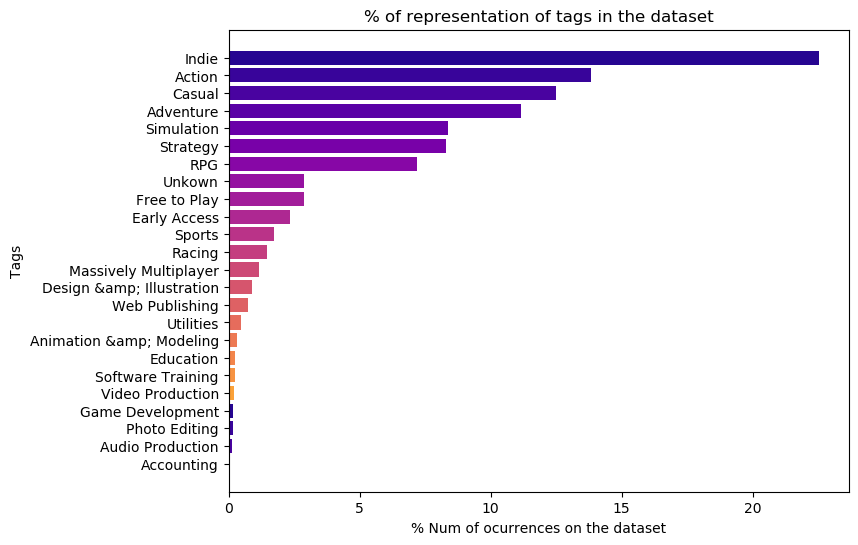

top_5_representation 68.39%
amnt_picked_representation 100.0%


,genre
Indie,22.54
Action,13.83
Casual,12.52
Adventure,11.15
Simulation,8.36
Strategy,8.30
RPG,7.17
Unkown,2.89
Free to Play,2.87
Early Access,2.33


In [59]:
AMNT_TAGS_TO_SEE = 24

y_labels = []
for i in range(AMNT_TAGS_TO_SEE):
    y_labels.append(genres_df['genre'].value_counts().keys()[:AMNT_TAGS_TO_SEE][i])

cmap = cm.get_cmap('plasma')

color = []
for i in range(20):
    color.append(cmap(i * 10 + 10))
    
gen_amnt = (genres_df["genre"].value_counts()[:AMNT_TAGS_TO_SEE] / len(genres_df)) * 100 # getting the %
gen_amnt = gen_amnt.sort_values(ascending=False)

plt.rcdefaults()
fig, ax = plt.subplots(figsize =(8, AMNT_TAGS_TO_SEE / 4))

ax.barh(y_labels, gen_amnt,  align='center', color =  color)
ax.set_yticks(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% Num of ocurrences on the dataset')
ax.set_ylabel('Tags')
ax.set_title('% of representation of tags in the dataset')
plt.show()

top_5_representation = round(gen_amnt[:5].sum(),2)
amnt_picked_representation = round(gen_amnt[:AMNT_TAGS_TO_SEE].sum(),2)
print(f'top_5_representation {top_5_representation}%\namnt_picked_representation {amnt_picked_representation}%')
pd.DataFrame(round(gen_amnt,2)).sort_values('genre',ascending=False)

The most common genres are the same as the most common tags (Indie,Action ,Casual, Simulation and Adventure) they represent 68% of the games

In [71]:
gen_scores = {}
gen_list = list(genres_df['genre'].value_counts().keys())

for gen in gen_list:
    data['is_gen_in_genres']=[are_tags_in_list(genres,gen) for genres in data['genres']]
    gen_scores[gen] = data.loc[data.is_gen_in_genres == True]['metascore'].mean()
    
data_items = gen_scores.items()
gen_score_df = pd.DataFrame(list(data_items)) 

gen_score_df = gen_score_df.rename(columns={0:'genre',1:'avg_score'},inplace=False)
gen_score_df['avg_score'] = round(gen_score_df['avg_score'],2)
gen_score_df = gen_score_df.sort_values('avg_score',ascending=False)

gen_score_df

,genre,avg_score
9,Early Access,78.33
12,Massively Multiplayer,75.31
8,Free to Play,73.88
7,Unkown,73.45
6,RPG,72.91
5,Strategy,72.69
10,Sports,72.01
3,Adventure,71.85
2,Casual,71.83
1,Action,71.74


The most popular genres are MMO, early access ,Free to play ,rpg and strategy

In [69]:
gen_score_df.describe()

,avg_score
count,13.000000
mean,72.972308
std,1.967482
min,71.460000
25%,71.740000
50%,72.010000
75%,73.450000
max,78.330000


In [72]:
#Going to fill null values with mean
gen_score_df['avg_score'] = gen_score_df['avg_score'].fillna(round(gen_score_df['avg_score'].mean(),2))
gen_score_df = gen_score_df.sort_values('avg_score',ascending=False)
gen_score_df

,genre,avg_score
9,Early Access,78.33
12,Massively Multiplayer,75.31
8,Free to Play,73.88
7,Unkown,73.45
14,Web Publishing,72.97
22,Audio Production,72.97
21,Photo Editing,72.97
20,Game Development,72.97
19,Video Production,72.97
18,Software Training,72.97


## Summary of what we learned so far respective to the tag and genres cols:
* Most liked genres are Early Access, MMO, Free To play and RPG.
* Most liked tags are Rock Music, Nature, Experimental, Top-down and strategy.
* 68% of the games are from Indie, Action, Casual, Simulation and Adventure genres and as tags they can be found in 22% of the games.
* Most common tag is Indie with 6.5% representation.

### As for the missing metascore values
I can calculate a more accurate user score with the mean scores of the tag_score_avg and gen_score_avg  by calculateing the mean of all tags and genres scores convined, as for unknowns I'll use the avg of the metascores after. 

After fixing the metascores I'll see how the avg score of each genre evolved over time.